In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns 
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import stats
from scipy.stats import uniform, truncnorm, randint
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-modelling/Churn_Modelling.csv


# Get the Data

In [2]:
df = pd.read_csv('../input/churn-modelling/Churn_Modelling.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


# 2. EDA

In [4]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [5]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## Numerical features

* CreditScore
* Age
* Tenure
* Balance
* NumOfProducts
* EstimatedSalary

In [6]:
df_num = df[['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary']]

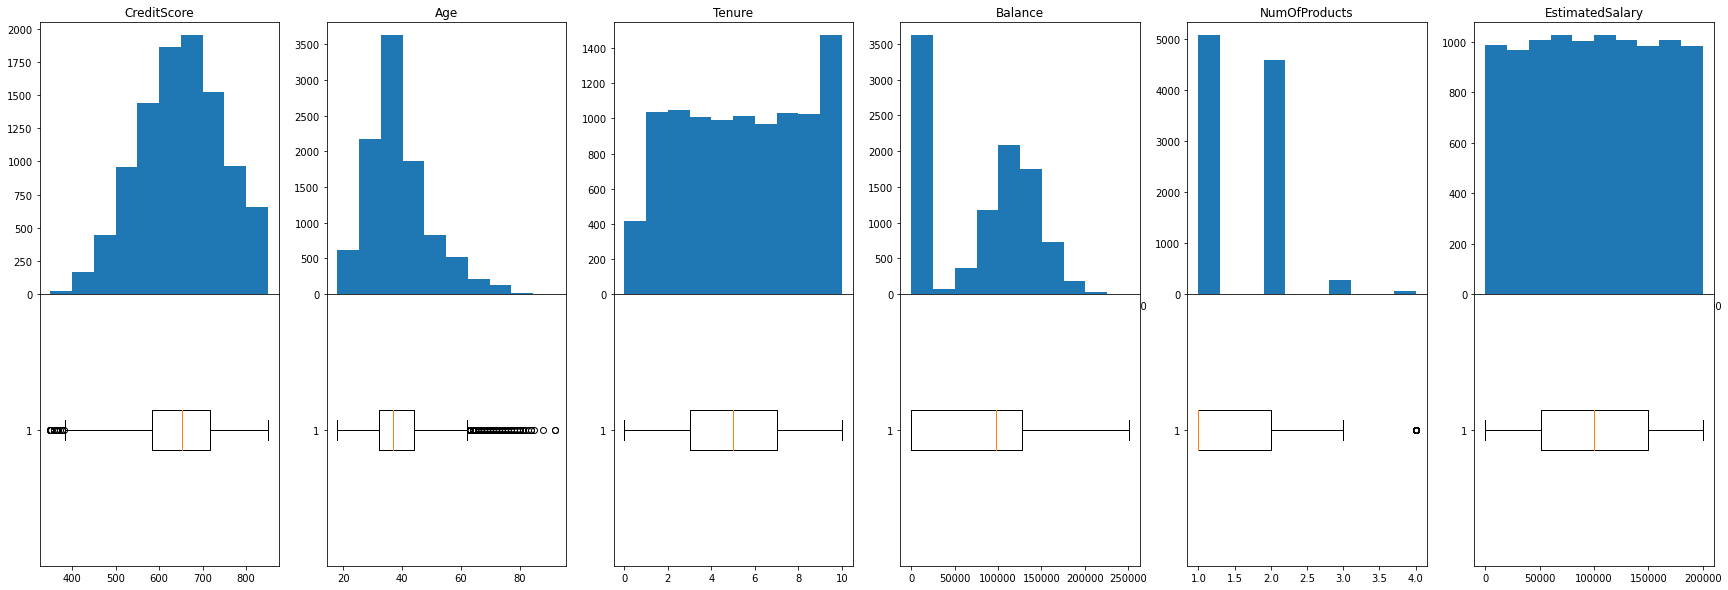

In [7]:
fig = plt.figure(figsize=(30,10))
gs = fig.add_gridspec(2, df_num.shape[1], hspace=0)
axs = gs.subplots()

for idx,col in enumerate(df_num.columns):
    axs[0, idx].hist(df_num[col])
    axs[0, idx].title.set_text(col)
    axs[1, idx].boxplot(df_num[col], vert=False)
plt.show()    

EstimatedSalary feature is uniformly distributed. For now I will keep it like that, but in the future I might do a Box-Muller transformation to the feature, because normally distributed features might help linear models.

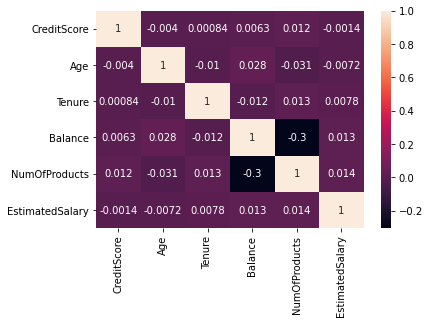

In [8]:
ax = sns.heatmap(df_num.corr(), annot=True)

## Categorical features

* Geography
* Gender
* HasCrCard
* IsActiveMember

In [9]:
df_cat = df[['Geography','Gender','HasCrCard','IsActiveMember']]

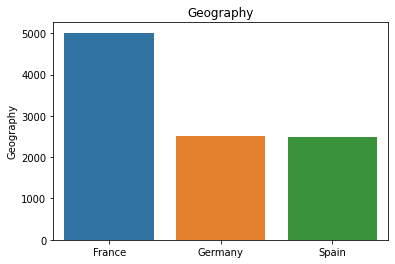

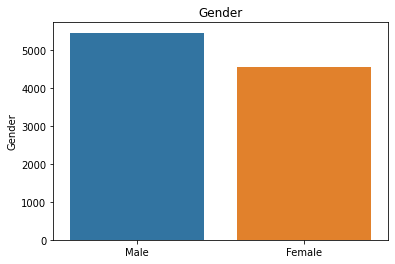

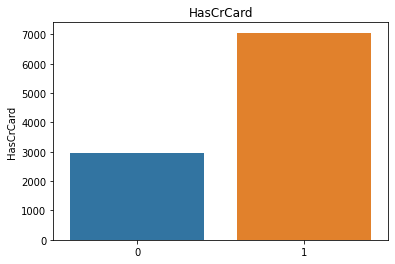

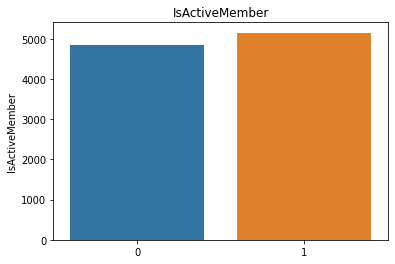

In [10]:
for i in df_cat.columns:
    sns.barplot(df_cat[i].value_counts().index,df_cat[i].value_counts()).set_title(i)
    plt.show()

## Target

* Exited

Text(0.5, 1.0, 'Exited')

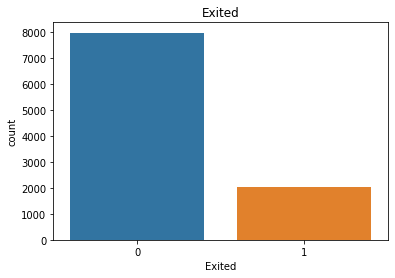

In [11]:
sns.countplot(df['Exited']).set_title('Exited')

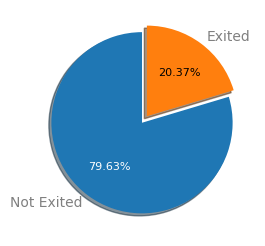

In [12]:
values = df.Exited.value_counts()
labels = ['Not Exited', 'Exited']

fig, ax = plt.subplots(figsize = (4, 3), dpi = 100)
explode = (0, 0.09)

patches, texts, autotexts = ax.pie(values, labels = labels, autopct = '%1.2f%%', shadow = True,
                                   startangle = 90, explode = explode)

plt.setp(texts, color = 'grey')
plt.setp(autotexts, size = 8, color = 'white')
autotexts[1].set_color('black')
plt.show()

## Combinations

In [13]:
# compare Exit rate across CreditScore, Age, Tenure, Balance, NumOfProducts, EstimatedSalary (numericals)
pd.pivot_table(df, index = 'Exited', values = df_num.columns)

,Age,Balance,CreditScore,EstimatedSalary,NumOfProducts,Tenure
Exited,,,,,,
0,37.408389,72745.296779,651.853196,99738.391772,1.544267,5.033279
1,44.837997,91108.539337,645.351497,101465.677531,1.475209,4.932744


In [14]:
df.columns

Index(['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited'],
      dtype='object')

### Exited - Geography

In [15]:
df[['Exited','Geography']].groupby('Geography').agg(['mean','count']).sort_values(by=('Exited','mean'), ascending=False)

Exited      
               mean count
Geography                
Germany    0.324432  2509
Spain      0.166734  2477
France     0.161548  5014

<AxesSubplot:xlabel='Geography', ylabel='count'>

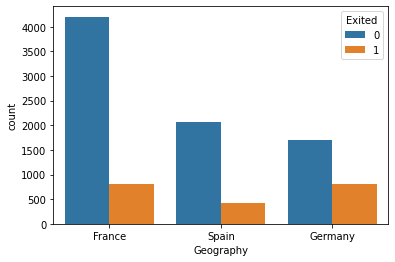

In [16]:
sns.countplot('Geography', hue = 'Exited', data = df)

* Half the customers are from France, and the other half is divided almost equally between Spain and Germany.
* Interestingly, the churning rate from German employees is much higher than the other two countries.

### Exited - Gender

In [17]:
df[['Exited','Gender']].groupby('Gender').agg(['mean','count']).sort_values(by=('Exited','mean'), ascending=False)

Exited      
            mean count
Gender                
Female  0.250715  4543
Male    0.164559  5457

<AxesSubplot:xlabel='Gender', ylabel='count'>

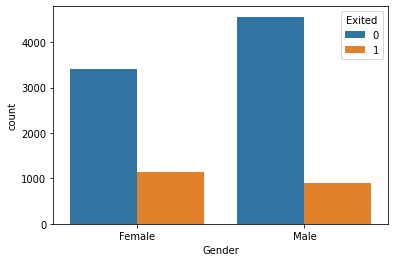

In [18]:
sns.countplot('Gender', hue = 'Exited', data = df)

* The churning rate for females is considerably higher than that for males.

### Exited - HasCrCard

In [19]:
df[['Exited','HasCrCard']].groupby('HasCrCard').agg(['mean','count']).sort_values(by=('Exited','mean'), ascending=False)

Exited      
               mean count
HasCrCard                
0          0.208149  2945
1          0.201843  7055

<AxesSubplot:xlabel='HasCrCard', ylabel='count'>

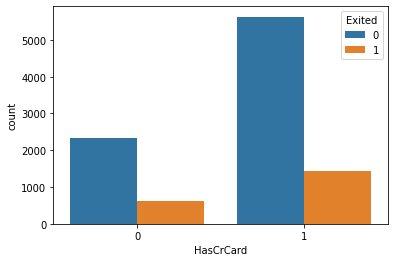

In [20]:
sns.countplot('HasCrCard', hue = 'Exited', data = df)

* 70% of the employees do have a credit card.
* The churning rate is the almost exactly the same for the two categories.

### Exited - IsActiveMember

In [21]:
df[['Exited','IsActiveMember']].groupby('IsActiveMember').agg(['mean','count']).sort_values(by=('Exited','mean'), ascending=False)

Exited      
                    mean count
IsActiveMember                
0               0.268509  4849
1               0.142691  5151

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

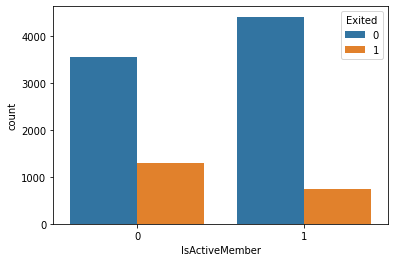

In [22]:
sns.countplot('IsActiveMember', hue = 'Exited', data = df)

* The active / not active members are almost 50-50.
* The churning rate for active members is considerably higher than that for not active members.

### Exited - NumOfProducts

In [23]:
df[['Exited','NumOfProducts']].groupby('NumOfProducts').agg(['mean','count']).sort_values(by=('Exited','mean'), ascending=False)

Exited      
                   mean count
NumOfProducts                
4              1.000000    60
3              0.827068   266
1              0.277144  5084
2              0.075817  4590

<AxesSubplot:xlabel='NumOfProducts', ylabel='count'>

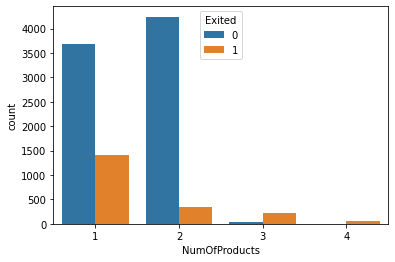

In [24]:
sns.countplot('NumOfProducts', hue = 'Exited', data = df)

* 96% of the employees have either 1 or 2 products (almost 50-50 between each)
* However, for 3 or 4 products the MCR is way higher than the GMCR. More interestingly, 100% of the employees who own 4 products have exited.

### Exited - Tenure

In [25]:
df[['Exited','Tenure']].groupby('Tenure').agg(['mean','count']).sort_values(by=('Exited','mean'), ascending=False)

Exited      
            mean count
Tenure                
0       0.230024   413
1       0.224155  1035
9       0.216463   984
3       0.211100  1009
5       0.206522  1012
10      0.206122   490
4       0.205258   989
6       0.202689   967
8       0.192195  1025
2       0.191794  1048
7       0.172179  1028

<AxesSubplot:xlabel='Tenure', ylabel='count'>

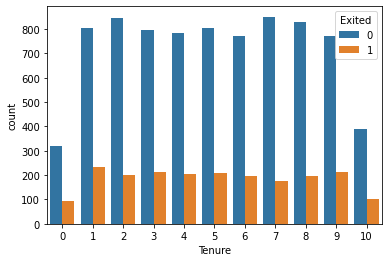

In [26]:
sns.countplot('Tenure', hue = 'Exited', data = df)

* Between 1 and 9 years, the feature is almost equally distributed (high variance). Only the extremes (0 and 10 years) have less density.
* There is not much insight in the MCR of each category, they are all close to the GMCR and there is not a clear correlation between Tenure and the CR.

### Exited - Balance

In [27]:
df[['Exited','Balance']].groupby('Exited').mean()

,Balance
Exited,
0,72745.296779
1,91108.539337


<AxesSubplot:xlabel='Exited', ylabel='Balance'>

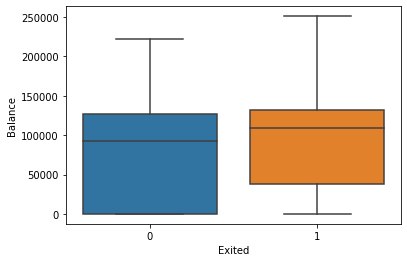

In [28]:
sns.boxplot(y='Balance', x='Exited', data=df, orient='v',)

In [29]:
# There are a lot of Employees with Balance = 0, so let's see the MCR for those
df[df['Balance'] == 0].mean()['Exited']

0.13823610727121924

* It is not a very big difference but Employees that have left tend to have higher Balance.
* For Employees with Balance = 0 the MCR is cosniderably lower than the GMCR.

### Exited - Age

In [30]:
# Divide Age into bins by decade
df['Age_bin'] = pd.cut(df['Age'], [0, 20, 30, 40, 50, 60, 70, 80, 90, 100])
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(40, 50]"
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(40, 50]"
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(40, 50]"
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(30, 40]"
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(40, 50]"


In [31]:
df[['Exited','Age_bin']].groupby('Age_bin').agg(['mean','count'])

Exited      
               mean count
Age_bin                  
(0, 20]    0.056180    89
(20, 30]   0.076104  1879
(30, 40]   0.120872  4451
(40, 50]   0.339655  2320
(50, 60]   0.562108   797
(60, 70]   0.314199   331
(70, 80]   0.082645   121
(80, 90]   0.100000    10
(90, 100]  0.000000     2

<AxesSubplot:xlabel='Age_bin', ylabel='count'>

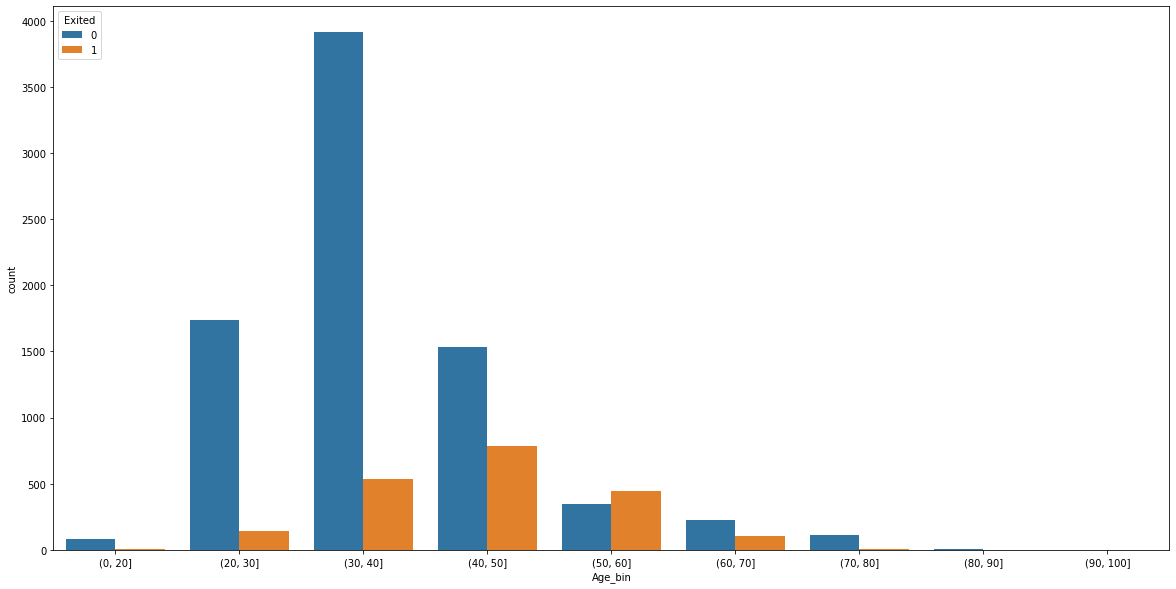

In [32]:
fig = plt.figure(figsize=(20,10))
sns.countplot('Age_bin', hue = 'Exited', data = df)

In [33]:
df['Exited'].mean()

0.2037

In [34]:
df[['Exited','Age_bin']].groupby('Age_bin').agg(['mean','count'])['Exited','mean']

Age_bin
(0, 20]      0.056180
(20, 30]     0.076104
(30, 40]     0.120872
(40, 50]     0.339655
(50, 60]     0.562108
(60, 70]     0.314199
(70, 80]     0.082645
(80, 90]     0.100000
(90, 100]    0.000000
Name: (Exited, mean), dtype: float64

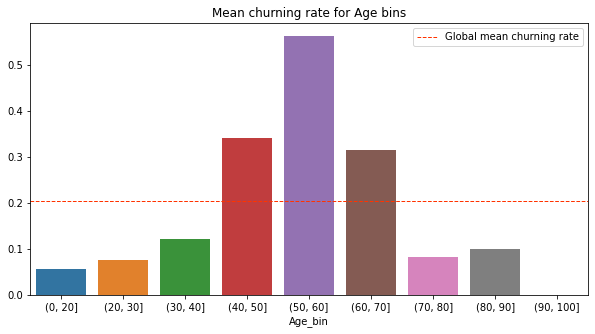

In [35]:
df_exited_agebin = df[['Exited','Age_bin']].groupby('Age_bin').agg(['mean','count'])['Exited','mean']

fig = plt.figure(figsize=(10,5))
sns.barplot(df_exited_agebin.index,df_exited_agebin.values).set_title('Mean churning rate for Age bins')
plt.axhline(y=df['Exited'].mean(), color='#ff3300', linestyle='--', linewidth=1, label='Global mean churning rate')
plt.legend()


General notes:
* Age follows a right skewed distribution.
* 45% of the employees are in the (30, 40] range of age.
* 87% of the employees are in the (20, 50] range of age.

Insights
* Global mean churning rate (GMCR): 20.37%
* (30, 40] mean churning rate: 34% --> CONSIDERABLY HIGHER THAN THE GLOBAL MEAN
* (40, 50] mean churning rate: 56% --> WAY HIGHER THAN THE GLOBAL MEAN
* (50, 60] mean churning rate: 31% --> CONSIDERABLY HIGHER THAN THE GLOBAL MEAN
* All the other bins (very young or very old) have way less mean churning rate than the global mean.
Summarizing, there are not Age bins with average MCR. There are some with much lower MCR (the extremes) and some with much higher MCR (the center)

I can further divide the age bins into three groups:
* (0,40]: MCR << GMCR
* (40,70]: MCR >> GMCR
* (70,100]: MCR << GMCR

In [36]:
# Divide Age into 3 further categories
df['Age_bin_3cat'] = pd.cut(df['Age'], [0, 40, 70, 100])
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin,Age_bin_3cat
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(40, 50]","(40, 70]"
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(40, 50]","(40, 70]"
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(40, 50]","(40, 70]"
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(30, 40]","(0, 40]"
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(40, 50]","(40, 70]"


In [37]:
df[['Exited','Age_bin_3cat']].groupby('Age_bin_3cat').agg(['mean','count'])

Exited      
                  mean count
Age_bin_3cat                
(0, 40]       0.106870  6419
(40, 70]      0.388631  3448
(70, 100]     0.082707   133

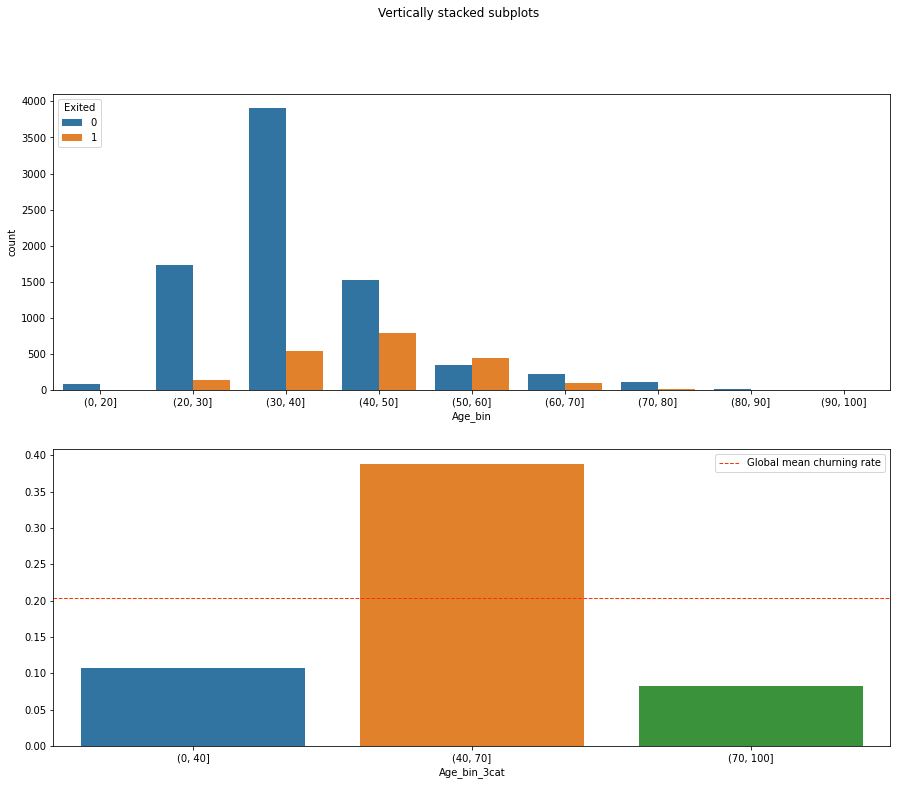

In [38]:
df_exited_agebin3cat = df[['Exited','Age_bin_3cat']].groupby('Age_bin_3cat').agg(['mean','count'])['Exited','mean']

fig, (ax1, ax2) = plt.subplots(2, figsize=(15,12))
fig.suptitle('Vertically stacked subplots')
sns.countplot('Age_bin', hue = 'Exited', data = df, ax=ax1)
sns.barplot(df_exited_agebin3cat.index,df_exited_agebin3cat.values, ax=ax2)
plt.axhline(y=df['Exited'].mean(), color='#ff3300', linestyle='--', linewidth=1, label='Global mean churning rate')
plt.legend()

* Raw Age data distribution (right skewed):

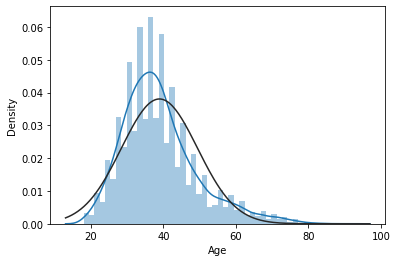

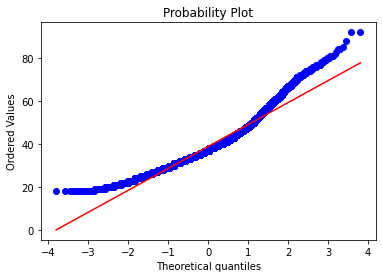

In [39]:
#histogram and normal probability plot
sns.distplot(df['Age'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['Age'], plot=plt)

* Log transformed Age data distribution (resembles normal):

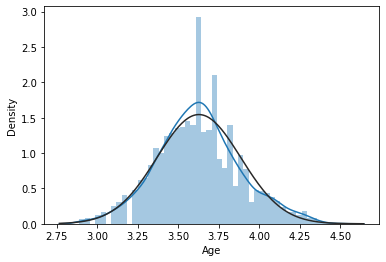

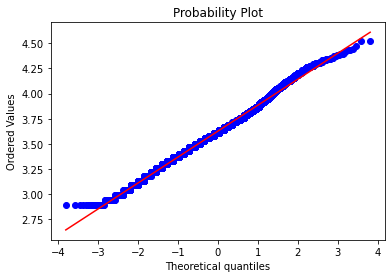

In [40]:
#histogram and normal probability plot
sns.distplot(np.log(df['Age']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(df['Age']), plot=plt)

* Box-Cox transformed Age data distribution (resembles normal):

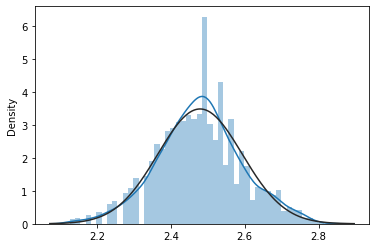

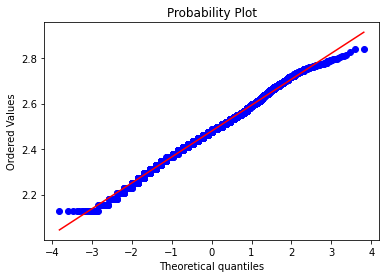

In [41]:
#histogram and normal probability plot
fitted_data, fitted_lambda = stats.boxcox(df['Age'])
sns.distplot(fitted_data, fit=norm);
fig = plt.figure()
res = stats.probplot(fitted_data, plot=plt)

By taking the log or Box-Cox transformation of the 'Age' feature, the positive skewed distribution becomes close to a normal one. \

I will add a Box-Cox transformed Age column in the Feature Engineering section, as a normally distributed feature it might help linear models.

In [42]:
df['Age_BoxCox'] = fitted_data

### Exited - CreditScore - EstimatedSalary

In [43]:
df[['Exited','CreditScore','EstimatedSalary']].groupby('Exited').mean()

,CreditScore,EstimatedSalary
Exited,,
0,651.853196,99738.391772
1,645.351497,101465.677531


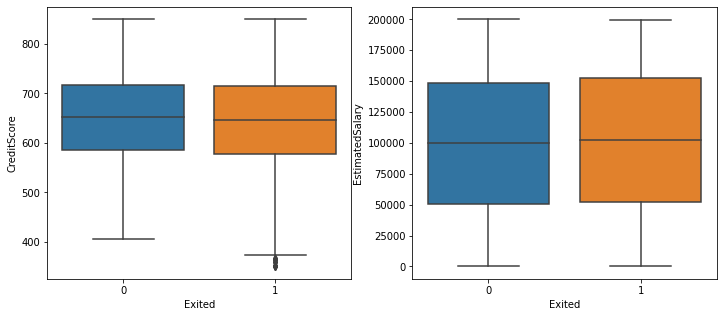

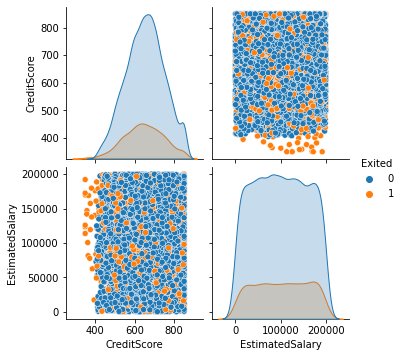

In [44]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

sns.boxplot(y='CreditScore', x='Exited', data=df, orient='v', ax=axes[0])
sns.boxplot(y='EstimatedSalary', x='Exited', data=df, orient='v', ax=axes[1])
sns.pairplot(df, vars = df[['CreditScore','EstimatedSalary']], hue ='Exited')


There is not much difference. The only thing I can see is that people with really low CreditScore (<400) have a much higher CR.

In order to explore this I will divide the Employees into CreditScore bins, according to this page:
https://www.equifax.com/personal/education/credit/score/what-is-a-credit-score/

I will add an extra category with CreditScore <400 because that is where I see most clear trend.

In [45]:
# Divide CreditScore into 6 categories
df['CreditScore_bin'] = pd.cut(df['CreditScore'], [0, 400, 579, 669, 739, 799, 850])
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin,Age_bin_3cat,Age_BoxCox,CreditScore_bin
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(40, 50]","(40, 70]",2.530867,"(579, 669]"
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(40, 50]","(40, 70]",2.520415,"(579, 669]"
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(40, 50]","(40, 70]",2.530867,"(400, 579]"
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(30, 40]","(0, 40]",2.498541,"(669, 739]"
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(40, 50]","(40, 70]",2.541019,"(799, 850]"


In [46]:
df[['Exited','CreditScore_bin','EstimatedSalary']].groupby('CreditScore_bin').agg({'Exited': 'mean', 'EstimatedSalary': ['mean','count']})

Exited EstimatedSalary      
                     mean            mean count
CreditScore_bin                                
(0, 400]         1.000000   127822.029474    19
(400, 579]       0.213828   100495.544725  2343
(579, 669]       0.205644    99406.521591  3331
(669, 739]       0.186161   100523.540918  2428
(739, 799]       0.205882    99752.096242  1224
(799, 850]       0.195420   100338.736473   655

We see something really interesting: ALL the 19 Employees that have a CreditScore<400 have left the company. But what is more strange is that the employees in this group have a much higher Mean EstimatedSalary than all the other categories. This is really counter-intuitive, as one might think that people that make more money are less likely to have lower CreditScore.

This may be an error in the dataset.

### Exited - Geography - EstimatedSalary

In [47]:
df[['Exited','Geography','EstimatedSalary']].groupby('Geography').agg({'Exited': 'mean', 'EstimatedSalary': ['mean','count']})

Exited EstimatedSalary      
               mean            mean count
Geography                                
France     0.161548    99899.180814  5014
Germany    0.324432   101113.435102  2509
Spain      0.166734    99440.572281  2477

* As we've seen before, German Employees have higher MCR. However, it seems they have slightly higher EstimatedSalary than employees from France or Spain, which seems counter-intuitive.
* The differences in EstimatedSalary for each country are very small, so I don't think this is relevant.

### Exited - Geography - Gender

In [48]:
df[['Exited','Geography','Gender']].groupby(['Geography','Gender']).agg(['mean','count'])

Exited      
                      mean count
Geography Gender                
France    Female  0.203450  2261
          Male    0.127134  2753
Germany   Female  0.375524  1193
          Male    0.278116  1316
Spain     Female  0.212121  1089
          Male    0.131124  1388

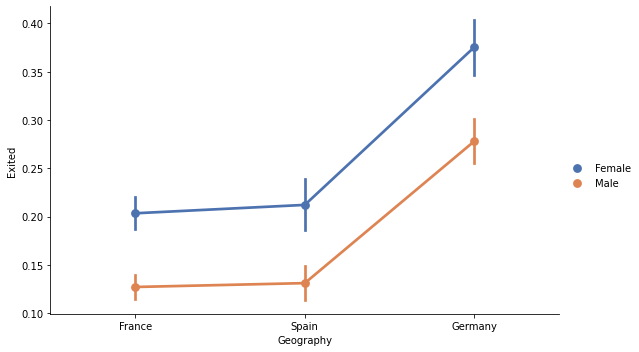

In [49]:
grid = sns.FacetGrid(df, height=5, aspect=1.6)
grid.map(sns.pointplot, 'Geography', 'Exited', 'Gender', palette='deep')
grid.add_legend()

* Females have higher MCR than males in every country.
* German employees have higher MCR than the other 2 countries for the same Gender.

### EstimatedSalary - Geography - Gender

In [50]:
df[['EstimatedSalary','Geography','Gender']].groupby(['Geography','Gender']).mean()

EstimatedSalary
Geography Gender                 
France    Female     99564.252755
          Male      100174.252495
Germany   Female    102446.424124
          Male       99905.033959
Spain     Female    100734.107475
          Male       98425.687680

* Not much information given, values are similar without clear trends.

### Exited - Numerical features

In [51]:
df_num

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary
0,619,42,2,0.00,1,101348.88
1,608,41,1,83807.86,1,112542.58
2,502,42,8,159660.80,3,113931.57
3,699,39,1,0.00,2,93826.63
4,850,43,2,125510.82,1,79084.10
...,...,...,...,...,...,...
9995,771,39,5,0.00,2,96270.64
9996,516,35,10,57369.61,1,101699.77
9997,709,36,7,0.00,1,42085.58
9998,772,42,3,75075.31,2,92888.52


<AxesSubplot:title={'center':'Pearson Correlation of Features'}>

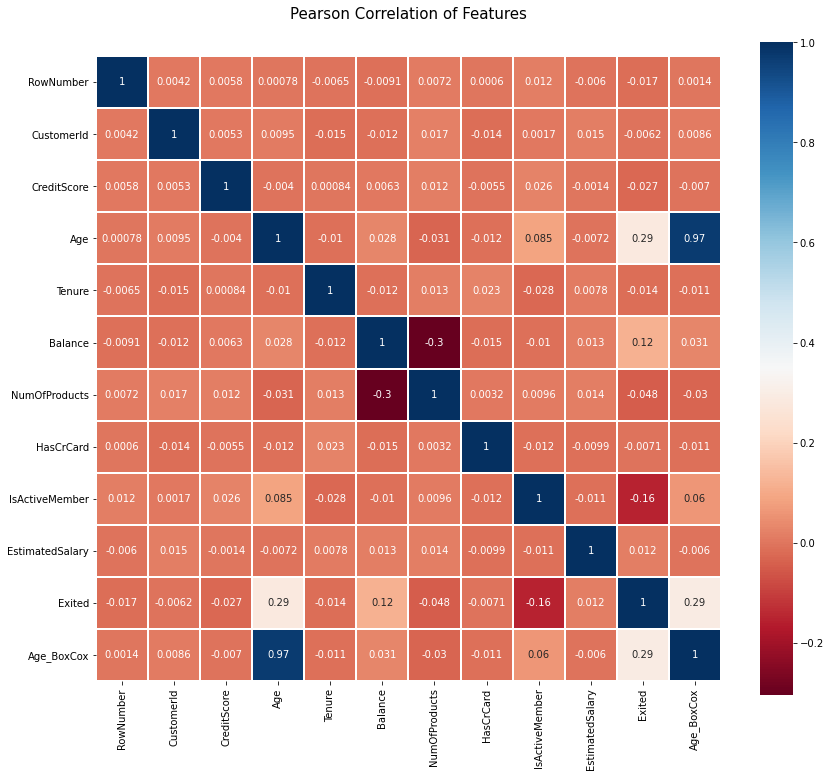

In [52]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(df.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

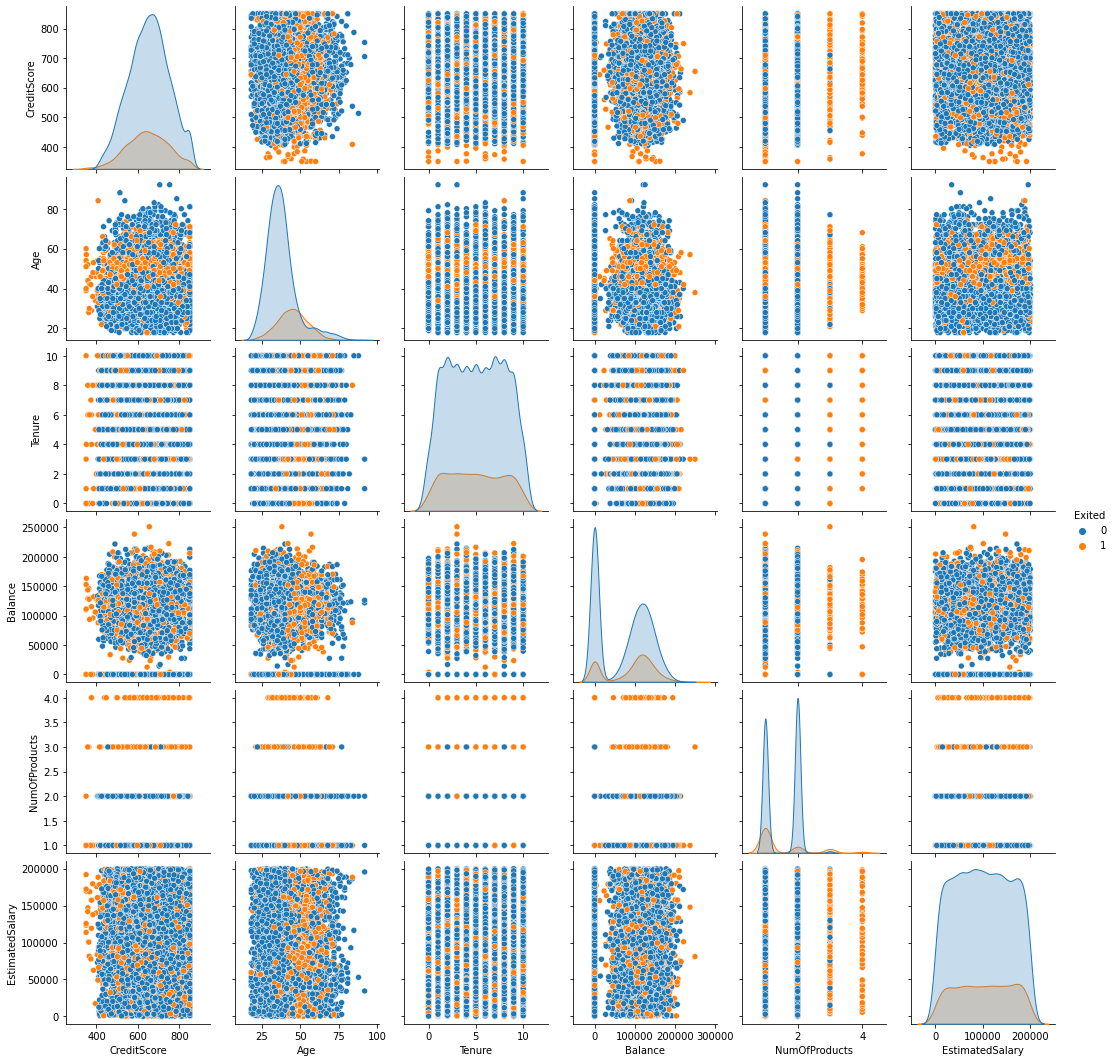

In [53]:
sns.pairplot(df, vars = df_num.columns, hue ='Exited')

From the numerical category pairplots we can get the following insights:
* There is very little correlation between the different features, so there is not visible redundance or multicollinearity (with the Pearson matrix only Balance-NumOfProducts show some negative correlation, but it is not so clear in the heatmap.
* It seems that for high 'NumOfProducts' values, the employee is more likely to leave (Exited=1).
* It seems like for very low CreditScore values, the employee is more likely to leave (Exited=1). A possible explanation is that maybe someone with poor CreditScore would want to get a job with better payment. However, it doesn't seem that people with lower EstimatedSalary have worse CreditScore (corr: -0.0014).

## Feature Engineering

In [54]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin,Age_bin_3cat,Age_BoxCox,CreditScore_bin
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(40, 50]","(40, 70]",2.530867,"(579, 669]"
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(40, 50]","(40, 70]",2.520415,"(579, 669]"
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(40, 50]","(40, 70]",2.530867,"(400, 579]"
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(30, 40]","(0, 40]",2.498541,"(669, 739]"
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(40, 50]","(40, 70]",2.541019,"(799, 850]"


First of all, I will get rid of the 'RowNumber', 'CustomerId' & 'Surname' columns as they don't provide useful information.

In [55]:
df = df.iloc[:,3:]

df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin,Age_bin_3cat,Age_BoxCox,CreditScore_bin
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1,"(40, 50]","(40, 70]",2.530867,"(579, 669]"
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,"(40, 50]","(40, 70]",2.520415,"(579, 669]"
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,"(40, 50]","(40, 70]",2.530867,"(400, 579]"
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0,"(30, 40]","(0, 40]",2.498541,"(669, 739]"
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,"(40, 50]","(40, 70]",2.541019,"(799, 850]"


### Categorical variables

* Geography
* Gender

In [56]:
# Convert variables using get_dummies
df = pd.get_dummies(df, columns=['Geography','Gender'])

df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Age_bin,Age_bin_3cat,Age_BoxCox,CreditScore_bin,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,"(40, 50]","(40, 70]",2.530867,"(579, 669]",1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,"(40, 50]","(40, 70]",2.520415,"(579, 669]",0,0,1,1,0
2,502,42,8,159660.80,3,1,0,113931.57,1,"(40, 50]","(40, 70]",2.530867,"(400, 579]",1,0,0,1,0
3,699,39,1,0.00,2,0,0,93826.63,0,"(30, 40]","(0, 40]",2.498541,"(669, 739]",1,0,0,1,0
4,850,43,2,125510.82,1,1,1,79084.10,0,"(40, 50]","(40, 70]",2.541019,"(799, 850]",0,0,1,1,0


### Numerical Variables

#### Age

Age seems to be an important feature, so I will combine it with other 2 continuous numerical features that don't seem to have a clear relation with the outcome: CreditScore and EstimatedSalary.

This way, I will create 2 ratios:
* CreditScore/Age
* EstimatedSalary/Age
This approach follows a Weak heredity implementation, in which one explores the interaction effect between a feature that is correlated with the outcome (Age) and a feature that is not (CreditScore and EstimatedSalary).

May be this relations will unveil some hidden relationships with the outcome.

This interactions were not just random, but have interpretability. One could think that both the Credit Score and the Salary of a given individual can have some sort of relationship with his/her Age.

In [57]:
df['ratio_CreditScore_Age'] = df['CreditScore']/df['Age']
df['ratio_EstimatedSalary_Age'] = df['EstimatedSalary']/df['Age']

#### Ordinal Variables

* Age_bin
* Age_bin_3cat
* CreditScore_bin



I am going to create the following datasets, following different approaches on the ordinal features. This way, I can afterwards train the same models on every one of this datasets and see which one yields the best performance.

**df_1**: Leave 'Age' and 'CreditScore' as continuous variables.\
**df_2**: Drop 'Age' and 'CreditScore', keep 'Age_bin' and 'CreditScore_bin'\
**df_3**: Drop 'Age' and 'CreditScore', keep 'Age_bin_3cat' and 'CreditScore_bin'\
**df_4**: Transform 'Age' with Box-Cox transformation to normalize it.

In [58]:
# cols_todrop_1 = ['Age_bin','Age_bin_3cat','CreditScore_bin','Age_BoxCox']
# cols_todrop_2 = ['Age','CreditScore','Age_bin_3cat','Age_BoxCox']
# cols_todrop_3 = ['Age','CreditScore','Age_bin','Age_BoxCox']
# cols_todrop_4 = ['Age','Age_bin','Age_bin_3cat','CreditScore_bin']

# df_1 = df.drop(cols_todrop_1, axis=1)
# df_2 = df.drop(cols_todrop_2, axis=1)
# df_3 = df.drop(cols_todrop_3, axis=1)
# df_4 = df.drop(cols_todrop_4, axis=1)

# df_2['Age_bin'] = df_2['Age_bin'].cat.codes
# df_2['CreditScore_bin'] = df_2['CreditScore_bin'].cat.codes
# df_3['Age_bin_3cat'] = df_3['Age_bin_3cat'].cat.codes
# df_3['CreditScore_bin'] = df_3['CreditScore_bin'].cat.codes

In [59]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()


## Shortlist Promising Models

### Approach

#### Features

I will test 4 different datasets, according to what I explained in the previous section:
* df_1
* df_2
* df_3
* df_4\
I will train models in each one to test the Feature Engineering techniques I used.

#### Performance metrics

* Confusion matrix
* Precision-Recall
* Sensitivity-Specificity
* F1-Score
* ROC-AUC\
I will use all of them to get a better sense of what's going on

#### Resampling

* Under-sampling
* Over-sampling
* SMOTE\
I will test the 3 techniques and see which one yields the best results

#### Models

* Naive Bayes
* Logistic Regression
* SVM
* Random Forest
* XGBoost\
I will test every model with each of the 4 prepared datasets and the 3 resampling techniques without hyperparameter tuning.\
Finally, I will select the model, dataset and resampling technique with the best performance, and perform hyperparameter tuning with that one.

### Data preparation

In [60]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, recall_score, precision_score, f1_score, accuracy_score, precision_recall_curve, roc_auc_score, classification_report, confusion_matrix

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

In [61]:
X = df.drop('Exited', axis=1)
y = df['Exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=11)

In [62]:
X_train

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_bin,Age_bin_3cat,Age_BoxCox,CreditScore_bin,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,ratio_CreditScore_Age,ratio_EstimatedSalary_Age
6614,689,34,1,165312.27,1,1,0,155495.63,"(30, 40]","(0, 40]",2.437258,"(669, 739]",1,0,0,0,1,20.264706,4573.400882
2694,628,29,3,113146.98,2,0,1,124749.08,"(20, 30]","(0, 40]",2.363809,"(579, 669]",0,1,0,0,1,21.655172,4301.692414
7439,432,27,6,62339.81,2,0,0,53874.67,"(20, 30]","(0, 40]",2.329951,"(400, 579]",1,0,0,1,0,16.000000,1995.358148
3062,582,40,9,0.00,3,1,1,60954.45,"(30, 40]","(0, 40]",2.509645,"(579, 669]",1,0,0,1,0,14.550000,1523.861250
1902,773,33,10,0.00,1,1,1,98820.09,"(30, 40]","(0, 40]",2.423673,"(739, 799]",0,0,1,1,0,23.424242,2994.548182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,712,29,7,147199.07,1,1,1,84932.40,"(20, 30]","(0, 40]",2.363809,"(669, 739]",0,1,0,1,0,24.551724,2928.703448
9014,596,60,7,121907.97,1,0,1,30314.04,"(50, 60]","(40, 70]",2.679151,"(579, 669]",0,0,1,0,1,9.933333,505.234000
8031,666,36,6,0.00,2,1,0,176692.87,"(30, 40]","(0, 40]",2.463018,"(579, 669]",0,0,1,1,0,18.500000,4908.135278
9153,507,36,9,118214.32,3,1,0,119110.03,"(30, 40]","(0, 40]",2.463018,"(400, 579]",0,1,0,0,1,14.083333,3308.611944


In [63]:
cols_todrop_1 = ['Age_bin','Age_bin_3cat','CreditScore_bin','Age_BoxCox']
cols_todrop_2 = ['Age','CreditScore','Age_bin_3cat','Age_BoxCox']
cols_todrop_3 = ['Age','CreditScore','Age_bin','Age_BoxCox']
cols_todrop_4 = ['Age','Age_bin','Age_bin_3cat','CreditScore_bin']

X1_train = X_train.drop(cols_todrop_1, axis=1)
X1_test = X_test.drop(cols_todrop_1, axis=1)
X2_train = X_train.drop(cols_todrop_2, axis=1)
X2_test = X_test.drop(cols_todrop_2, axis=1)
X3_train = X_train.drop(cols_todrop_3, axis=1)
X3_test = X_test.drop(cols_todrop_3, axis=1)
X4_train = X_train.drop(cols_todrop_4, axis=1)
X4_test = X_test.drop(cols_todrop_4, axis=1)

X2_train['Age_bin'] = X2_train['Age_bin'].cat.codes
X2_test['Age_bin'] = X2_test['Age_bin'].cat.codes
X2_train['CreditScore_bin'] = X2_train['CreditScore_bin'].cat.codes
X2_test['CreditScore_bin'] = X2_test['CreditScore_bin'].cat.codes
X3_train['Age_bin_3cat'] = X3_train['Age_bin_3cat'].cat.codes
X3_test['Age_bin_3cat'] = X3_test['Age_bin_3cat'].cat.codes
X3_train['CreditScore_bin'] = X3_train['CreditScore_bin'].cat.codes
X3_test['CreditScore_bin'] = X3_test['CreditScore_bin'].cat.codes

In [64]:
def fit_model(X, y, model, string):
    
    pipeline_under = imbpipeline(steps = [['under', RandomUnderSampler(random_state=11)],
                                        ['scaler', StandardScaler()],
                                        ['classifier', model()]])
    
    pipeline_over = imbpipeline(steps = [['over', RandomOverSampler()],
                                        ['scaler', StandardScaler()],
                                        ['classifier', model()]])
    
    pipeline_smote = imbpipeline(steps = [['smote', SMOTE(random_state=11)],
                                        ['scaler', StandardScaler()],
                                        ['classifier', model()]])
    
    stratified_kfold = StratifiedKFold(n_splits=5,
                                       shuffle=True,
                                       random_state=11)
    
    scores_under = cross_val_score(pipeline_under, X, y, scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)
    scores_over = cross_val_score(pipeline_over, X, y, scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)
    scores_smote = cross_val_score(pipeline_smote, X, y, scoring='roc_auc', cv=stratified_kfold, n_jobs=-1)
    
#     param_grid = {'classifier__C':[0.001, 0.01, 0.1, 1, 10, 100, 1000]}
#     grid_search = GridSearchCV(estimator=pipeline,
#                                param_grid=param_grid,
#                                scoring='roc_auc',
#                                cv=stratified_kfold,
#                                n_jobs=-1)
    
    
#     grid_search.fit(X_train, y_train)
#     cv_score = grid_search.best_score_
#     test_score = grid_search.score(X_test, y_test)
#     return {'cv_score':cv_score, 'test_score':test_score}
    print('-----------------------------------------------------')
    print(string)
    print('UNDERSAMPLING Mean ROC AUC: %.3f' % scores_under.mean())
    print('OVERSAMPLING Mean ROC AUC: %.3f' % scores_over.mean())
    print('SMOTE Mean ROC AUC: %.3f' % scores_smote.mean())
#     print(scores_under)
#     print(scores_over)
#     print(scores_smote)

* **Gaussian Naive Bayes:**

In [65]:
fit_model(X1_train, y_train, GaussianNB, 'Feature set 1')
fit_model(X2_train, y_train, GaussianNB, 'Feature set 2')
fit_model(X3_train, y_train, GaussianNB, 'Feature set 3')
fit_model(X4_train, y_train, GaussianNB, 'Feature set 4')

-----------------------------------------------------
Feature set 1
UNDERSAMPLING Mean ROC AUC: 0.784
OVERSAMPLING Mean ROC AUC: 0.785
SMOTE Mean ROC AUC: 0.758
-----------------------------------------------------
Feature set 2
UNDERSAMPLING Mean ROC AUC: 0.782
OVERSAMPLING Mean ROC AUC: 0.782
SMOTE Mean ROC AUC: 0.742
-----------------------------------------------------
Feature set 3
UNDERSAMPLING Mean ROC AUC: 0.787
OVERSAMPLING Mean ROC AUC: 0.788
SMOTE Mean ROC AUC: 0.744
-----------------------------------------------------
Feature set 4
UNDERSAMPLING Mean ROC AUC: 0.786
OVERSAMPLING Mean ROC AUC: 0.786
SMOTE Mean ROC AUC: 0.759


* **Logistic Regression:**

In [66]:
fit_model(X1_train, y_train, LogisticRegression, 'Feature set 1')
fit_model(X2_train, y_train, LogisticRegression, 'Feature set 2')
fit_model(X3_train, y_train, LogisticRegression, 'Feature set 3')
fit_model(X4_train, y_train, LogisticRegression, 'Feature set 4')

-----------------------------------------------------
Feature set 1
UNDERSAMPLING Mean ROC AUC: 0.768
OVERSAMPLING Mean ROC AUC: 0.768
SMOTE Mean ROC AUC: 0.757
-----------------------------------------------------
Feature set 2
UNDERSAMPLING Mean ROC AUC: 0.767
OVERSAMPLING Mean ROC AUC: 0.766
SMOTE Mean ROC AUC: 0.753
-----------------------------------------------------
Feature set 3
UNDERSAMPLING Mean ROC AUC: 0.773
OVERSAMPLING Mean ROC AUC: 0.773
SMOTE Mean ROC AUC: 0.755
-----------------------------------------------------
Feature set 4
UNDERSAMPLING Mean ROC AUC: 0.770
OVERSAMPLING Mean ROC AUC: 0.770
SMOTE Mean ROC AUC: 0.758


* **Support Vector Machines:**

In [67]:
fit_model(X1_train, y_train, LinearSVC, 'Feature set 1')
fit_model(X2_train, y_train, LinearSVC, 'Feature set 2')
fit_model(X3_train, y_train, LinearSVC, 'Feature set 3')
fit_model(X4_train, y_train, LinearSVC, 'Feature set 4')

-----------------------------------------------------
Feature set 1
UNDERSAMPLING Mean ROC AUC: 0.768
OVERSAMPLING Mean ROC AUC: 0.768
SMOTE Mean ROC AUC: 0.755
-----------------------------------------------------
Feature set 2
UNDERSAMPLING Mean ROC AUC: 0.767
OVERSAMPLING Mean ROC AUC: 0.767
SMOTE Mean ROC AUC: 0.751
-----------------------------------------------------
Feature set 3
UNDERSAMPLING Mean ROC AUC: 0.773
OVERSAMPLING Mean ROC AUC: 0.774
SMOTE Mean ROC AUC: 0.755
-----------------------------------------------------
Feature set 4
UNDERSAMPLING Mean ROC AUC: 0.770
OVERSAMPLING Mean ROC AUC: 0.771
SMOTE Mean ROC AUC: 0.758


* **Random Forest:**

In [68]:
fit_model(X1_train, y_train, RandomForestClassifier, 'Feature set 1')
fit_model(X2_train, y_train, RandomForestClassifier, 'Feature set 2')
fit_model(X3_train, y_train, RandomForestClassifier, 'Feature set 3')
fit_model(X4_train, y_train, RandomForestClassifier, 'Feature set 4')

-----------------------------------------------------
Feature set 1
UNDERSAMPLING Mean ROC AUC: 0.840
OVERSAMPLING Mean ROC AUC: 0.847
SMOTE Mean ROC AUC: 0.839
-----------------------------------------------------
Feature set 2
UNDERSAMPLING Mean ROC AUC: 0.835
OVERSAMPLING Mean ROC AUC: 0.839
SMOTE Mean ROC AUC: 0.829
-----------------------------------------------------
Feature set 3
UNDERSAMPLING Mean ROC AUC: 0.835
OVERSAMPLING Mean ROC AUC: 0.838
SMOTE Mean ROC AUC: 0.828
-----------------------------------------------------
Feature set 4
UNDERSAMPLING Mean ROC AUC: 0.839
OVERSAMPLING Mean ROC AUC: 0.845
SMOTE Mean ROC AUC: 0.839


* **XGBoost:**

In [69]:
fit_model(X1_train, y_train, xgb.XGBClassifier, 'Feature set 1')
fit_model(X2_train, y_train, xgb.XGBClassifier, 'Feature set 2')
fit_model(X3_train, y_train, xgb.XGBClassifier, 'Feature set 3')
fit_model(X4_train, y_train, xgb.XGBClassifier, 'Feature set 4')

-----------------------------------------------------
Feature set 1
UNDERSAMPLING Mean ROC AUC: 0.830
OVERSAMPLING Mean ROC AUC: 0.834
SMOTE Mean ROC AUC: 0.837
-----------------------------------------------------
Feature set 2
UNDERSAMPLING Mean ROC AUC: 0.827
OVERSAMPLING Mean ROC AUC: 0.837
SMOTE Mean ROC AUC: 0.835
-----------------------------------------------------
Feature set 3
UNDERSAMPLING Mean ROC AUC: 0.827
OVERSAMPLING Mean ROC AUC: 0.834
SMOTE Mean ROC AUC: 0.833
-----------------------------------------------------
Feature set 4
UNDERSAMPLING Mean ROC AUC: 0.830
OVERSAMPLING Mean ROC AUC: 0.842
SMOTE Mean ROC AUC: 0.839


The best performer was:
* Feature set 4
* Over-sampling
* Random Forest Model

It is a little bit strange because Feature set 4 is the one where I used the Log transformation in the Age variable. This should not matter in a tree based method like Random Forest. In addition, XGBoost which is another tree based had also good performance in this dataset.

## Fine-Tune the System

### Chosen model: Random Forest

First of all, I will see the results in the previous section more in depth to see what is going on.

#### Plot ROC AUC with different Resampling methods

In [70]:
# Initialize Model and Pipeline with all the resampling methods

classifier = RandomForestClassifier()

scaler = StandardScaler()

pipeline = [
    make_pipeline(RandomUnderSampler(random_state=11), scaler, classifier),
    make_pipeline(RandomOverSampler(random_state=11), scaler, classifier),
    make_pipeline(SMOTE(random_state=11), scaler, classifier),
]

In [71]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

In [72]:
X, y = X4_train, y_train

In [73]:
X.reset_index(drop=True, inplace=True)
X

,CreditScore,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Age_BoxCox,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male,ratio_CreditScore_Age,ratio_EstimatedSalary_Age
0,689,1,165312.27,1,1,0,155495.63,2.437258,1,0,0,0,1,20.264706,4573.400882
1,628,3,113146.98,2,0,1,124749.08,2.363809,0,1,0,0,1,21.655172,4301.692414
2,432,6,62339.81,2,0,0,53874.67,2.329951,1,0,0,1,0,16.000000,1995.358148
3,582,9,0.00,3,1,1,60954.45,2.509645,1,0,0,1,0,14.550000,1523.861250
4,773,10,0.00,1,1,1,98820.09,2.423673,0,0,1,1,0,23.424242,2994.548182
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,712,7,147199.07,1,1,1,84932.40,2.363809,0,1,0,1,0,24.551724,2928.703448
7996,596,7,121907.97,1,0,1,30314.04,2.679151,0,0,1,0,1,9.933333,505.234000
7997,666,6,0.00,2,1,0,176692.87,2.463018,0,0,1,1,0,18.500000,4908.135278
7998,507,9,118214.32,3,1,0,119110.03,2.463018,0,1,0,0,1,14.083333,3308.611944


In [74]:
y.reset_index(drop=True, inplace=True)
y

0       0
1       0
2       0
3       0
4       0
       ..
7995    0
7996    0
7997    0
7998    1
7999    1
Name: Exited, Length: 8000, dtype: int64

The positive label considered as the minority class is 1


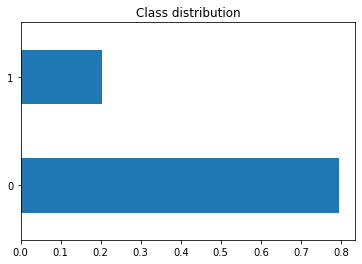

In [75]:
class_distribution = pd.Series(y).value_counts(normalize=True)
ax = class_distribution.plot.barh()
ax.set_title("Class distribution")
pos_label = class_distribution.idxmin()
print(f"The positive label considered as the minority class is {pos_label}")

In [76]:
disp = []
for model in pipeline:
    # compute the mean fpr/tpr to get the mean ROC curve
    mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        y_proba = model.predict_proba(X.iloc[test])

        pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
        fpr, tpr, thresholds = roc_curve(
            y[test], y_proba[:, pos_label_idx], pos_label=pos_label
        )
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Create a display that we will reuse to make the aggregated plots for
    # all methods
    disp.append(
        RocCurveDisplay(
            fpr=mean_fpr,
            tpr=mean_tpr,
            roc_auc=mean_auc,
            estimator_name=f"{model[0].__class__.__name__}",
        )
    )

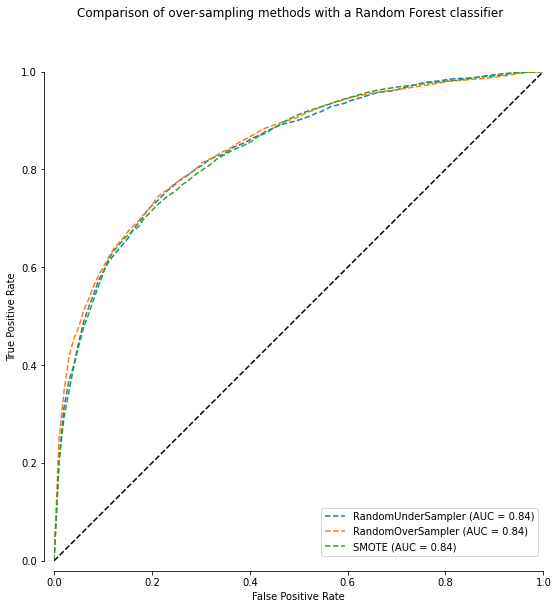

In [77]:
fig, ax = plt.subplots(figsize=(9, 9))
for d in disp:
    d.plot(ax=ax, linestyle="--")
ax.plot([0, 1], [0, 1], linestyle="--", color="k")
ax.axis("square")
fig.suptitle("Comparison of over-sampling methods with a Random Forest classifier")
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
sns.despine(offset=10, ax=ax)
plt.show()

We pretty much get the same ROC AUC regardless of the resampling method. I will further explore oversampling, as it was the one with the best results in the previous section.

#### AUC Performance measurement using 2 different codes

In order to see if the results are consistent, I will use the same pipeline (Oversampling, Standard Scaler, Random Forest Classifier) with 2 different codes (Option 1 & Option 2) and check the ROC AUC I get from each one.

* Option 1:

In [78]:
classifier = RandomForestClassifier()

scaler = StandardScaler()

pipeline_over = [make_pipeline(RandomOverSampler(random_state=11), scaler, classifier)]

# pipeline_over = imbpipeline(steps = [['over', RandomOverSampler(random_state=11)],
#                                         ['scaler', StandardScaler()],
#                                         ['classifier', model()]])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=11)

X, y = X4_train, y_train

In [79]:
disp = []
for model in pipeline_over:
    # compute the mean fpr/tpr to get the mean ROC curve
    mean_tpr, mean_fpr = 0.0, np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        model.fit(X.iloc[train], y.iloc[train])
        y_proba = model.predict_proba(X.iloc[test])

        pos_label_idx = np.flatnonzero(model.classes_ == pos_label)[0]
        fpr, tpr, thresholds = roc_curve(
            y[test], y_proba[:, pos_label_idx], pos_label=pos_label
        )
        mean_tpr += np.interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0

    mean_tpr /= cv.get_n_splits(X, y)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)

    # Create a display that we will reuse to make the aggregated plots for
    # all methods
#     disp.append(
#         RocCurveDisplay(
#             fpr=mean_fpr,
#             tpr=mean_tpr,
#             roc_auc=mean_auc,
#             estimator_name=f"{model[0].__class__.__name__}",
#         )
#     )

In [80]:
mean_auc

0.8442638332616135

* Option 2:

In [81]:
sss = StratifiedKFold(n_splits=5, random_state=11, shuffle=False)

# We will oversample during cross validating
oversample_X = X4_train
oversample_y = y_train
original_Xtrain = X4_train
original_ytrain = y_train

for train_index, test_index in sss.split(oversample_X, oversample_y):
    print("Train:", train_index, "Test:", test_index)
    oversample_Xtrain, oversample_Xtest = oversample_X.iloc[train_index], oversample_X.iloc[test_index]
    oversample_ytrain, oversample_ytest = oversample_y.iloc[train_index], oversample_y.iloc[test_index]
    
oversample_Xtrain = oversample_Xtrain.values
oversample_Xtest = oversample_Xtest.values
oversample_ytrain = oversample_ytrain.values
oversample_ytest = oversample_ytest.values 

oversample_accuracy = []
oversample_precision = []
oversample_recall = []
oversample_f1 = []
oversample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
# X_nearmiss, y_nearmiss = NearMiss().fit_sample(undersample_X.values, undersample_y.values)
# print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))

# Cross Validating the right way

for train, test in sss.split(oversample_Xtrain, oversample_ytrain):
    oversample_pipeline = imbpipeline(steps = [['over', RandomOverSampler(random_state=11)],
                                        ['scaler', StandardScaler()],
                                        ['classifier', RandomForestClassifier()]])
    oversample_model = oversample_pipeline.fit(oversample_Xtrain[train], oversample_ytrain[train])
    oversample_prediction_proba = oversample_model.predict_proba(oversample_Xtrain[test])
    oversample_prediction = oversample_model.predict(oversample_Xtrain[test])
    
    oversample_accuracy.append(oversample_pipeline.score(original_Xtrain.iloc[test], original_ytrain.iloc[test]))
    oversample_precision.append(precision_score(original_ytrain.iloc[test], oversample_prediction))
    oversample_recall.append(recall_score(original_ytrain.iloc[test], oversample_prediction))
    oversample_f1.append(f1_score(original_ytrain.iloc[test], oversample_prediction))
    oversample_auc.append(roc_auc_score(original_ytrain.iloc[test], oversample_prediction_proba[:,1]))

Train: [1445 1448 1455 ... 7997 7998 7999] Test: [   0    1    2 ... 1647 1648 1649]
Train: [   0    1    2 ... 7997 7998 7999] Test: [1445 1448 1455 ... 3249 3251 3252]
Train: [   0    1    2 ... 7997 7998 7999] Test: [2985 2989 2995 ... 4835 4836 4837]
Train: [   0    1    2 ... 7997 7998 7999] Test: [4608 4618 4622 ... 6445 6446 6447]
Train: [   0    1    2 ... 6445 6446 6447] Test: [6270 6273 6289 ... 7997 7998 7999]


In [82]:
# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(oversample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(oversample_precision)))
print("Recall Score: {:.2f}".format(np.mean(oversample_recall)))
print("F1 Score: {:.2f}".format(np.mean(oversample_f1)))
print("ROC AUC: {:.2f}".format(np.mean(oversample_auc)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.85
Precision Score: 0.68
Recall Score: 0.50
F1 Score: 0.58
ROC AUC: 0.83
---------------------------------------------------------------------------------------------------------------------------------------


The results of both of the methods are consistent, **the ROC AUC is 0,84**

Now I will plot the final results.

Random Forest ROC-AUC:  0.845601024742129


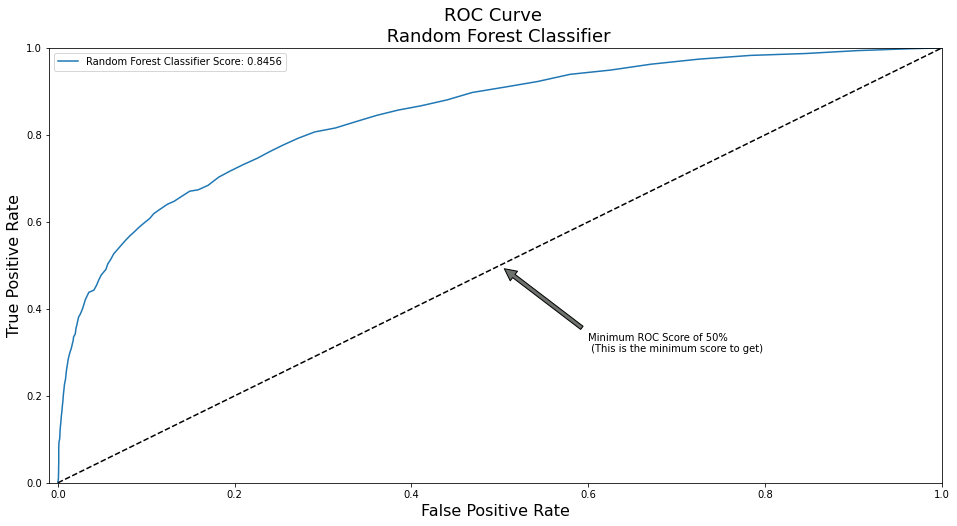

In [83]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

X4_train_scaled = scaler.fit_transform(X4_train)

rf = RandomForestClassifier(random_state=11)

rf_pred = cross_val_predict(rf, X4_train_scaled, y_train, cv=5, method="predict_proba")

print('Random Forest ROC-AUC: ', roc_auc_score(y_train, rf_pred[:,1]))

rf_fpr, rf_tpr, rf_thresold = roc_curve(y_train, rf_pred[:,1])

def graph_roc_curve(model_fpr, model_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Random Forest Classifier', fontsize=18)
    plt.plot(model_fpr, model_tpr, label='Random Forest Classifier Score: {:.4f}'.format(roc_auc_score(y_train, rf_pred[:,1])))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve(rf_fpr, rf_tpr)
plt.show()

#### Fine tuning using RandomizedSearchCV

In [84]:
# Initialize steps of the pipeline
oversampling = RandomOverSampler(random_state=11)
scaler = StandardScaler()
model = RandomForestClassifier(random_state=11)

# Pipeline
pipeline = make_pipeline(oversampling, scaler, model)

# Parameter grid
grid = {
    "randomforestclassifier__n_estimators": [10, 25, 50, 100, 250, 500, 750, 1000, 1250, 1500, 1750, 2000],
    "randomforestclassifier__criterion": ["gini", "entropy"],
    "randomforestclassifier__max_depth": [10, 20, 30, 40, 50, 75, 100, 150, 200, None],
    "randomforestclassifier__min_samples_split": [1, 2, 3, 4, 5, 8, 10, 15, 20],
    "randomforestclassifier__min_samples_leaf": [1, 2, 3, 4, 5, 8, 10, 15, 20],
    "randomforestclassifier__max_features": ["auto", None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
    "randomforestclassifier__bootstrap": [True, False],
    "randomforestclassifier__max_samples": [None, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
}

# Cross Validation
kf = StratifiedKFold(n_splits=5)

# RandomizedSearchCV using RFC model, RandomOverSampler & StandardScaler. Scoring is ROC-AUC
rand_rf = RandomizedSearchCV(pipeline, grid, scoring='roc_auc', n_iter=10, n_jobs=-1, cv=kf, random_state=11)

# Fit the model to the data
tuned_model = rand_rf.fit(X, y)

# Results
print(tuned_model.best_params_)
print('Best Score: %s' % tuned_model.best_score_)

{'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__min_samples_leaf': 8, 'randomforestclassifier__max_samples': 0.1, 'randomforestclassifier__max_features': 0.3, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
Best Score: 0.8559514981075015


In [85]:
# According to the previous results, I will further tune the model to reach the maximum possible performance

grid_2 = {
    "randomforestclassifier__n_estimators": [50, 75, 100, 120, 150, 200],
    "randomforestclassifier__criterion": ["entropy"],
    "randomforestclassifier__max_depth": [5, 7, 10, 12, 15],
    "randomforestclassifier__min_samples_split": [6, 7, 8, 9, 10],
    "randomforestclassifier__min_samples_leaf": [6, 7, 8, 9, 10],
    "randomforestclassifier__max_features": [0.2, 0.3, 0.4],
    "randomforestclassifier__bootstrap": [False],
    "randomforestclassifier__max_samples": [None, 0.1, 0.2],
}

kf = StratifiedKFold(n_splits=5)

rand_rf_2 = RandomizedSearchCV(pipeline, grid_2, scoring='roc_auc', n_iter=10, n_jobs=-1, cv=kf, random_state=11)

tuned_model_2 = rand_rf_2.fit(X, y)

print(tuned_model_2.best_params_)
print('Best Score: %s' % tuned_model_2.best_score_)

{'randomforestclassifier__n_estimators': 120, 'randomforestclassifier__min_samples_split': 6, 'randomforestclassifier__min_samples_leaf': 10, 'randomforestclassifier__max_samples': 0.2, 'randomforestclassifier__max_features': 0.4, 'randomforestclassifier__max_depth': 10, 'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__bootstrap': False}
Best Score: 0.8581806011692075


* **Final Training ROC-AUC: 0.858**

## Results: Test dataset Scores

Finally, I will use my final model on the Test dataset (which hasn't been used at all yet, and shouldn't be used for training) and see the scores I get.

In [86]:
labels = ['No Churn', 'Churn']
y_pred = tuned_model_2.predict(X4_test)
print(classification_report(y_test, y_pred, target_names=labels))

              precision    recall  f1-score   support

    No Churn       0.92      0.86      0.89      1593
       Churn       0.57      0.72      0.63       407

    accuracy                           0.83      2000
   macro avg       0.75      0.79      0.76      2000
weighted avg       0.85      0.83      0.84      2000



<AxesSubplot:>

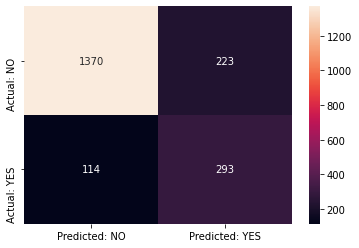

In [87]:
#Get the confusion matrix
cm = confusion_matrix(y_test, y_pred)

#Plot the confusion matrix
xlabels = ['Predicted: NO', 'Predicted: YES']
ylabels = ['Actual: NO', 'Actual: YES']
sns.heatmap(data=cm, xticklabels=xlabels, yticklabels=ylabels, annot=True, fmt='g')

In [88]:
roc_auc_score(y_test, y_pred)

0.7899571374147645

* **Final Test ROC-AUC: 0.79**

In [89]:
accuracy_score(y_test, y_pred)

0.8315

In [90]:
importance = tuned_model_2.best_estimator_[2].feature_importances_

In [91]:
def plot_feature_importance(importance, names, model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

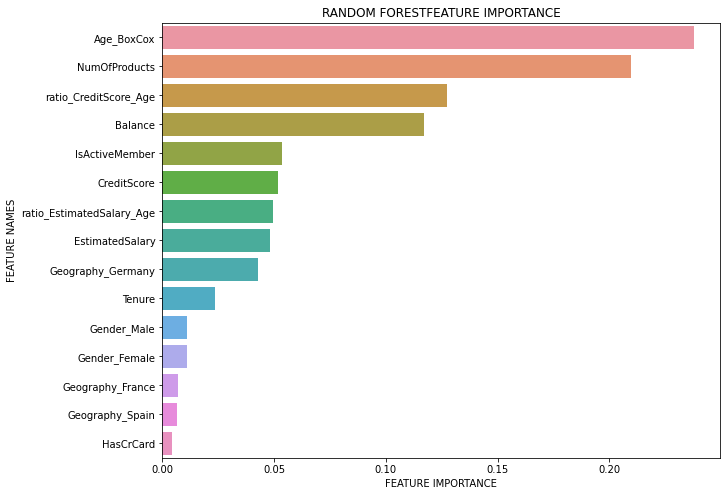

In [92]:
plot_feature_importance(importance, X.columns, 'RANDOM FOREST')

## Conclusions & Nest Steps

Conclusions:
* The final model is not very accurate in the test data (AUC=0.79). There seems to be overfitting, as the train score was 0.86. This may be due to the resampling technique I used, which is Oversampling.
* As suspected, the most important features are 'Age' 'NumOfProducts'. 'NumOfProducts' is a strange feature, and might be another reason for the overfitting. 'Age' is really important.
* 'Age_BoxCox' and 'ratio_CreditScore_Age', two of the three created features are in the Top-3 most important features. Particularly, 'ratio_CreditScore_Age' is an improvement from the plain 'CreditScore' feature. However, 'ratio_EstimatedSalary_Age' which is the other created feature, was not an improvement over 'EstimatedSalary'.
* Finally, it is worth mentioning that neither Gender nor Nationality were important.

Next Steps:
* Try not using the least important features. May be even 'NumOfProducts', because although it is very importante I think it is distorsive. This might help with the over-fitting. Also, I could try PCA or PLS for this.
* Try other reampling techniques. May be Under-sampling would reduce over-fitting. According to the results, it was not far behind Over-sampling in terms of training performance.
